# Calculate subsidence in BKK at wellnests with 8 aquifers but simulates top four.

- Plotting three main figures for _Groundwater_ Paper
- Data availability graph: Figure 1 in paper
- Groundwater well nest locations: Figure 6 in paper
- Basin wide pumping, groundwater well forecasts, subsidence forecasts for well nest BKK013: Figure 12 in paper

Article Title: Hybrid data-driven, physics-based modeling of groundwater and subsidence with application to Bangkok, Thailand

Author: Jenny Soonthornrangsan 2023, TU Delft

In [1]:
###############################################################################
# Installing packages on colab
###############################################################################
!pip install pastas
!pip install "basemap == 1.3.2" "basemap-data == 1.3.2" 
!pip install "basemap-data-hires == 1.3.2"
!pip install "matplotlib == 3.5.2"
!pip install mycolorpy
!pip install xlrd
!pip install pickle
!git clone https://github.com/jsoontho/BKKSubPastasModels.git
    
# Changing current directory to location of python script
%cd '/content/BKKSubPastasModels'

!git pull

  Using cached basemap-1.3.2.zip (155 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  pip subprocess to install build dependencies did not run successfully.
  exit code: 1
  
  [10 lines of output]
  Ignoring numpy: markers 'python_version == "2.7" or (python_version >= "3.4" and python_version <= "3.9")' don't match your environment
  Ignoring numpy: markers 'python_version == "2.6" or (python_version >= "3.2" and python_version <= "3.3")' don't match your environment
  Ignoring cython: markers 'python_version == "3.2"' don't match your environment
    Using cached setuptools-70.0.0-py3-none-any.whl.metadata (5.9 kB)
    Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
  ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
  ERROR: Could not find a version that satisfies the requirement numpy==1.21.4 (from version

  Using cached matplotlib-3.5.2.tar.gz (35.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for matplotlib
Failed to build matplotlib


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [600 lines of output]
  
  Edit mplsetup.cfg to change the build options; suppress output with --quiet.
  
  BUILDING MATPLOTLIB
        python: yes [3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023,
                    13:26:23) [MSC v.1916 64 bit (AMD64)]]
      platform: yes [win32]
         tests: no  [skipping due to configuration]
        macosx: no  [Mac OS-X only]
  
  C:\Users\jtsoonthornran\Anaconda3\Lib\site-packages\setuptools\__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


[WinError 3] The system cannot find the path specified: "'/content/BKKSubPastasModels'"
C:\Users\jtsoonthornran\BKKSubPastasModels\JupyterNotebooks


Cloning into 'BKKSubPastasModels'...
Updating files:  55% (195/353)
Updating files:  56% (198/353)
Updating files:  57% (202/353)
Updating files:  58% (205/353)
Updating files:  59% (209/353)
Updating files:  60% (212/353)
Updating files:  61% (216/353)
Updating files:  62% (219/353)
Updating files:  63% (223/353)
Updating files:  64% (226/353)
Updating files:  64% (228/353)
Updating files:  64% (229/353)
Updating files:  65% (230/353)
Updating files:  65% (231/353)
Updating files:  66% (233/353)
Updating files:  67% (237/353)
Updating files:  68% (241/353)
Updating files:  69% (244/353)
Updating files:  70% (248/353)
Updating files:  71% (251/353)
Updating files:  72% (255/353)
Updating files:  73% (258/353)
Updating files:  74% (262/353)
Updating files:  75% (265/353)
Updating files:  76% (269/353)
Updating files:  77% (272/353)
Updating files:  77% (275/353)
Updating files:  78% (276/353)
Updating files:  79% (279/353)
Updating files:  80% (283/353)
Updating files:  81% (286/353)
Up

__Note that if imports don't work. Check results from cell above and click `Restart Runtime.` Then rerun cells below (including import cell)__

In [2]:
###############################################################################
# import statements
###############################################################################

# Importing packages and libraries
import os
import pandas as pd
import numpy as np
import pastas as ps
import matplotlib.pyplot as plt
import datetime
from matplotlib.ticker import (AutoMinorLocator)
import string
import pickle
import sys

# Changing current directory to location of main directory
%cd "C:\Users\jtsoonthornran\BKKSubPastasModels"

# Bangkok Subsidence Model Package
import bkk_sub_gw

# Importing script for pre-processing Thai GW data
import main_functions as mfs

C:\Users\jtsoonthornran\BKKSubPastasModels


Figure with three plots (Figure 1 of paper)

*   a) Basin-wide pumping rates from 1978 to 2007.
*   b) The observed groundwater head for well PD32 of well nest BKK013 from 1988-2022. 
*   c) Observed annual subsidence rates from benchmark leveling station 5503. 

In [3]:
###############################################################################
# Plotting settings
###############################################################################

plt.rc("font", size=12)  # controls default text size
plt.rc("axes", titlesize=5)  # fontsize of the title
plt.rc("axes", labelsize=6)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=6)  # fontsize of the x tick labels
plt.rc("ytick", labelsize=6)  # fontsize of the y tick labels
plt.rc("legend", fontsize=6)  # fontsize of the legend

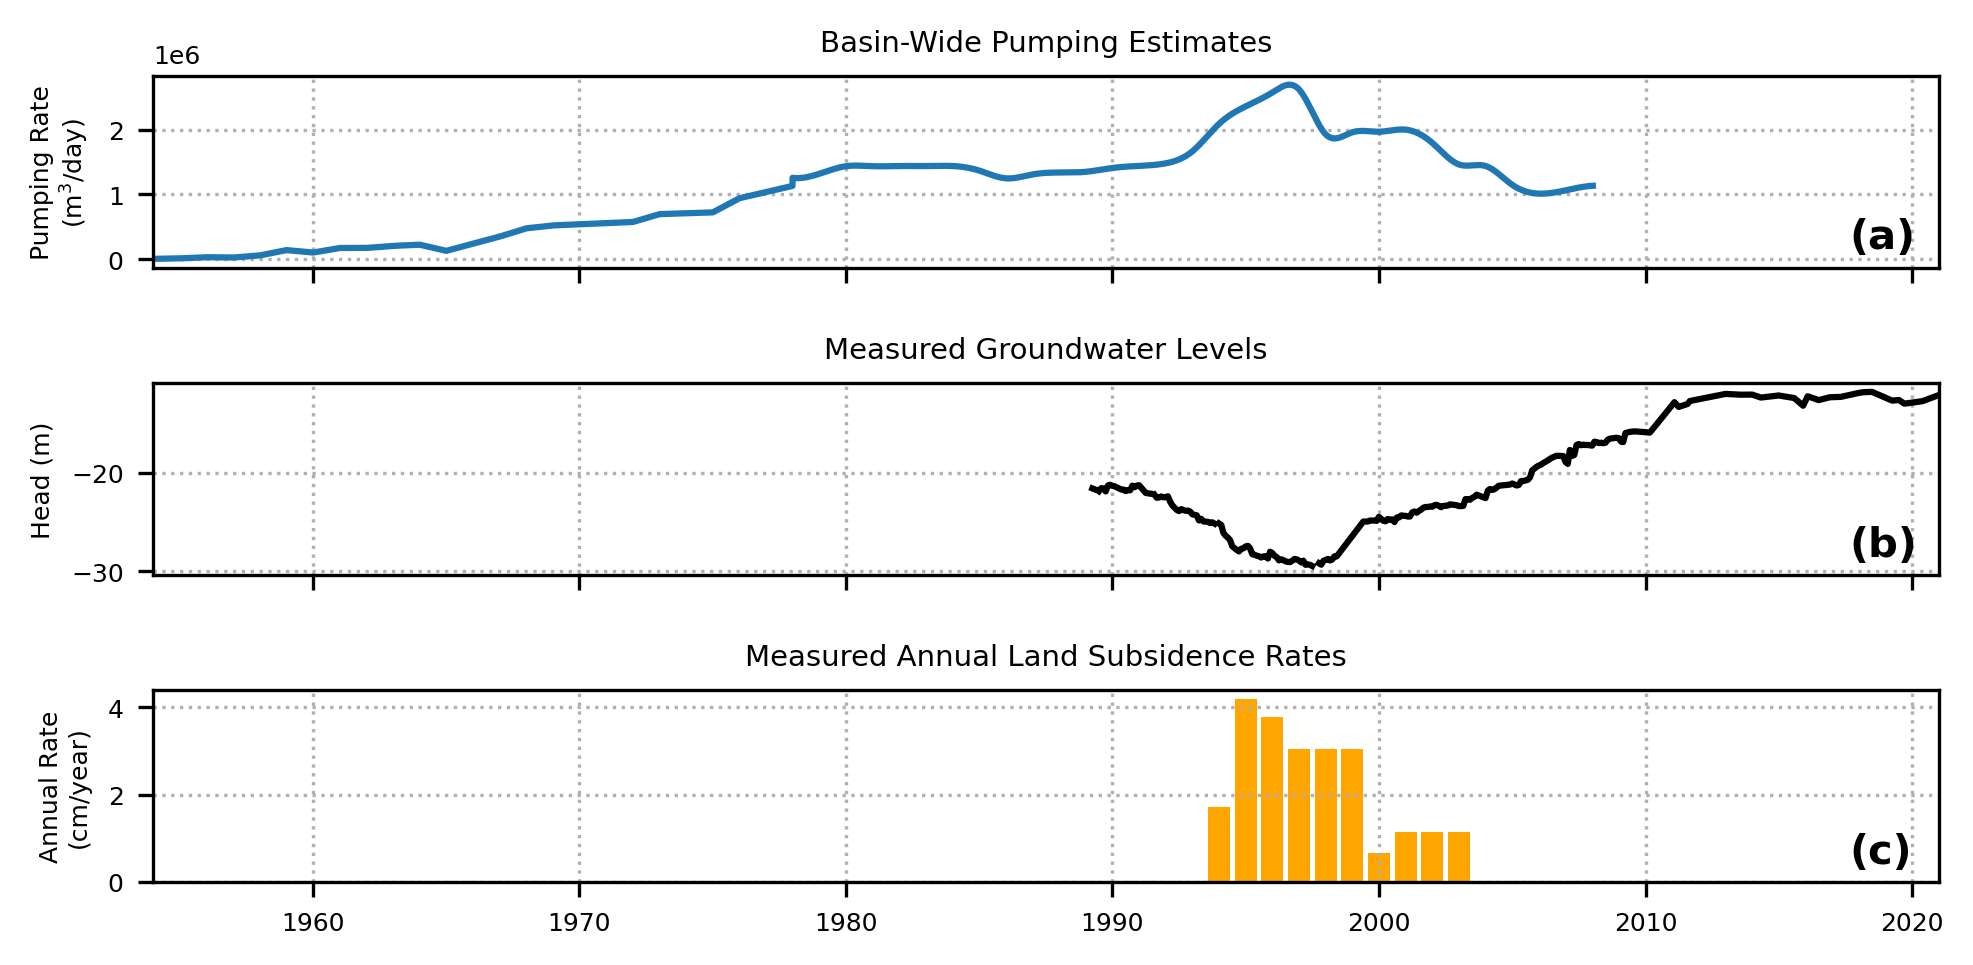

In [4]:
# %% Data availability
# Pumping vs groundwater vs levelling measurements

# Plotting pumping
# Reading in data
sheet = "EstTotalPump_54-60_Int50"
pumppath = "inputs\\BasinPumping.xlsx"
pump_2020 = pd.read_excel(pumppath, sheet_name=sheet)

# Xticks
x = pd.date_range(start=pump_2020.Date[0],
                  end=pump_2020.Date[19733],
                  periods=8)

# Plotting
fig, axs = plt.subplots(3, sharex=True, figsize=(6.75, 3.38), dpi=300)
axs[0].plot(pump_2020.Date[:19733], pump_2020.Pump2[:19733], linewidth=1.5)
axs[0].set_ylabel("Pumping Rate\n(m$^3$/day)")
axs[0].set_title("Basin-Wide Pumping Estimates",
                 fontsize=7)
axs[0].grid(True, linestyle="dotted")

# Plottign groundwater
# Reading in groundwater data
Wellnest_name = "LCBKK013"
well_name = "PD32"
well_path = "inputs\\"
full_path = os.path.join(well_path, Wellnest_name + ".xlsx")
data = pd.read_excel(full_path, skiprows=3)
all_head_data, gw_well_head = mfs.GW_Data_Process(data, well_name)

# CORRECTING GW HEAD DATA TO LAND SURFACE (COASTAL DEM 2.1)
landsurf_path = os.path.join(well_path,
                             "LandSurfElev_GWWellLocs.xlsx")

# Each well nest has its own Ss and K sheet
landsurf_data = pd.read_excel(landsurf_path,
                              sheet_name="2.1",
                              usecols="C:F",
                              index_col=0)

gw_well_head.Head += (landsurf_data.RASTERVALU.loc[Wellnest_name])
# Adding years and annual average heads
gw_well_head["year"] = gw_well_head.index.year
axs[1].plot(gw_well_head.index, gw_well_head.Head, color="k",
            linewidth=1.5)
axs[1].set_xlim(([datetime.date(1954, 1, 1), datetime.date(2020, 12, 31)]))
axs[1].set_ylabel("Head (m)")

# Detailed title
# axs[1].set_title("Measured Groundwater Levels for Well PD32 in Well Nest BKK013",
#                  fontsize=7)

# Generalized title
axs[1].set_title("Measured Groundwater Levels",
                 fontsize=7)
axs[1].grid(True, linestyle="dotted")
loc = os.path.join(os.path.abspath("inputs"), "SurveyingLevels.xlsx")

subdata = pd.read_excel(loc, sheet_name=Wellnest_name+"_Leveling",
                        index_col=3)
subdata = pd.DataFrame(subdata)
subdata.index = pd.to_datetime(subdata.index)

# Getting rid of benchmarks outside time period
subdata = subdata[(subdata.Year <= 2020)]

# Benchmarks should start at 0 at the first year.
bench = subdata.loc[:, subdata.columns.str.contains("Land")]
bench = bench.fillna(0)

if (bench.iloc[0] != 0).any():
    bench.iloc[0] = 0

# IMPORTANT INFO
# For benchmark measurements, the first year is 0, the second year is
# the compaction rate over that first year.
# For implicit Calc, the first year has a compaction rate over that
# year, so to shift benchmarks value to the previouse year to match
# Index has the right years
bench.index = bench.index.shift(-1, freq="D")
bench["date"] = bench.index

# Gets the last date of each year
lastdate = bench.groupby(pd.DatetimeIndex(bench["date"]).year,
                         as_index=False).agg({"date": max}).reset_index(drop=True)
bench = bench.loc[lastdate.date]

leveling = bench[
    bench.columns[
        bench.columns.str.contains("Land")].item()]

leveling[leveling == 0] = np.nan
axs[2].bar(leveling.index, -leveling.values, color="orange", width=300)
axs[2].xaxis_date()
axs[2].set_xlim(([datetime.date(1954, 1, 1), datetime.date(2020, 12, 31)]))
axs[2].set_ylabel("Annual Rate\n(cm/year)")
# Detailed title
# axs[2].set_title(
#     "Measured Annual Land Subsidence Rates from Benchmark Leveling Station 5503",
#     fontsize=7)
# Generalized title
axs[2].set_title(
    "Measured Annual Land Subsidence Rates",
    fontsize=7)
plt.tight_layout()
plt.rc("font", size=10)  # controls default text size
axs[2].grid(True, linestyle="dotted")

# a), b), c) labels for paper
for index, ax in enumerate(axs):

    ax.text(.95, .1, "(" + string.ascii_lowercase[index] + ")",
            transform=ax.transAxes,
            size=10, weight="bold")


Figure of spatial map of groundwater well nest (Figure 6 in paper). The yellow well nest location (BKK013) is referred to in Figures 1, 8, 11, and 13.

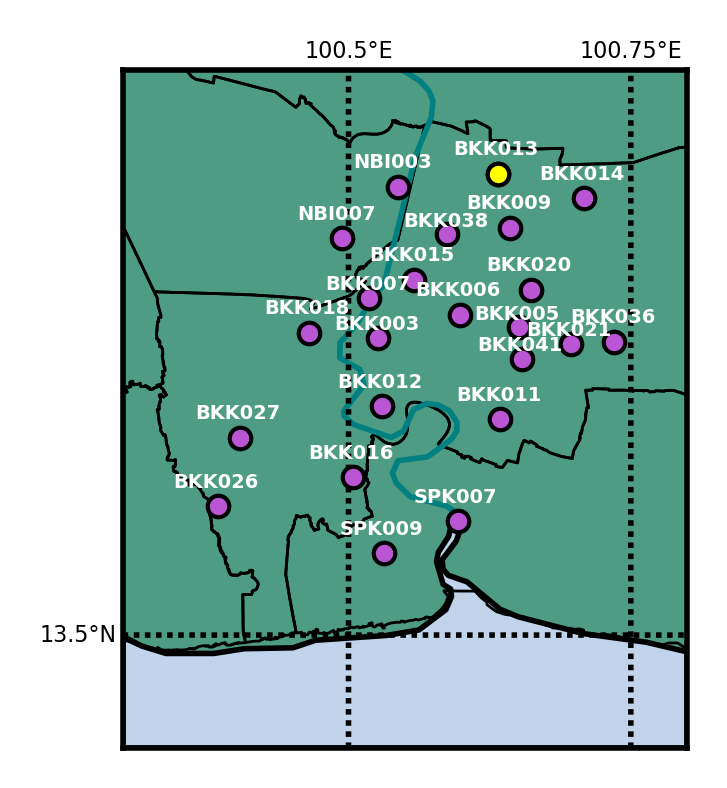

In [5]:
# %% Plotting groundwater well locations

path = os.path.abspath("figures")
bkk_sub_gw.bkk_plotting.gwlocs_map(path, save=0)

In [6]:
###############################################################################
# Plotting settings
###############################################################################

plt.rc("font", size=8)  # controls default text size
plt.rc("axes", titlesize=10)  # fontsize of the title
plt.rc("axes", labelsize=6)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=6)  # fontsize of the x tick labels
plt.rc("ytick", labelsize=6)  # fontsize of the y tick labels
plt.rc("legend", fontsize=5)  # fontsize of the legend
plt.rcParams["legend.title_fontsize"] = 6  # fontsize of legend title

Figure with three plots 

*   a) Basin-wide pumping rates from 1978 to 2060. 1978-2022 are historical rates and 2022-2060 are forecasted rates based on five scenarios. 
*   b) The simulated groundwater head for well PD32 of well nest BKK013 using the same scenarios as plot a). 
*   c) Cumulative subsidence starting in 1978 to 2060 using the same scenarios. The 2060 rates in mm/yr is reported in the lower left hand corner with respect to the scenarios. 

INFO: Time Series 'Head': 4 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file C:\Users\jtsoonthornran\BKKSubPastasModels\models\LCBKK013_PD32_GW_1978_2005_model.pas successfully loaded. This file was created with Pastas 1.3.0. Your current version of Pastas is: 1.3.0
INFO: Time Series 'Pump' was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series 'Pump' was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series 'Pump' was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series 'Pump' was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series 'Pump' was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series 'Head': 4 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCBKK013_PD32_GW_1978_2005_model.pas successfully loaded. This file w

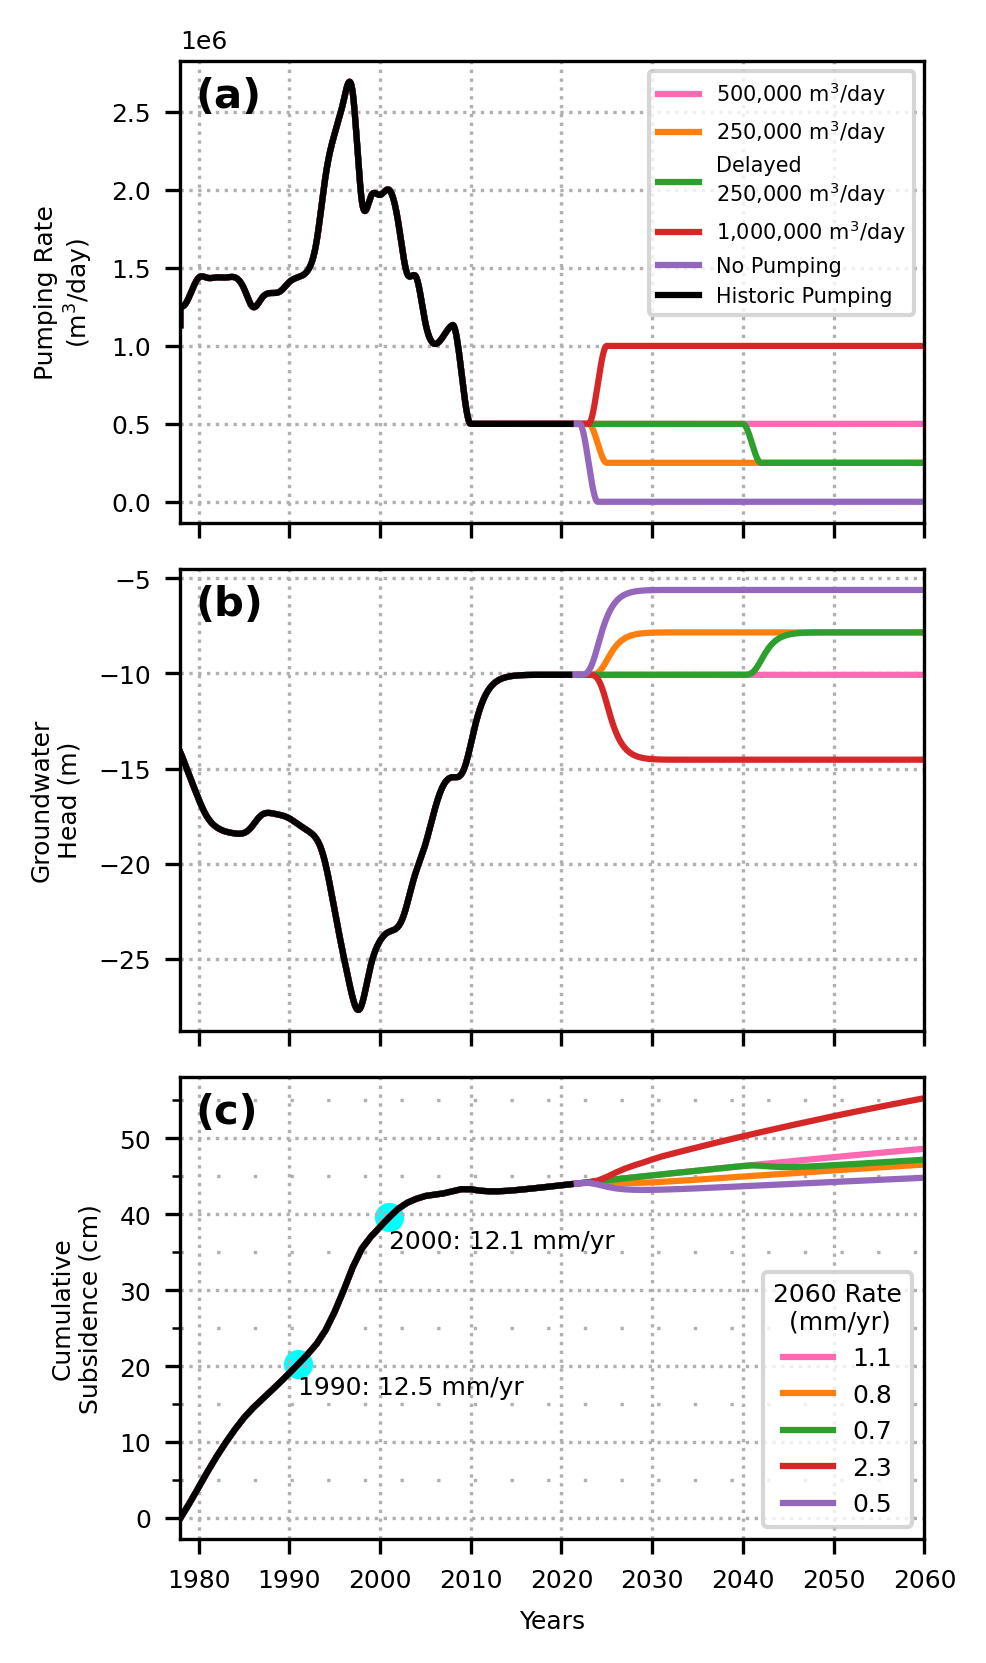

In [7]:
# Plotting pumping
# Reading in data
sheet = "EstTotalPump_54-60_Int50"
full_path = os.path.join(os.path.abspath("inputs"), "BasinPumping.xlsx")
pump_50 = pd.read_excel(full_path, sheet_name=sheet)
sheet = "EstTotalPump_54-60_IntF25"
pump_25 = pd.read_excel(full_path, sheet_name=sheet)
sheet = "EstTotalPump_54-60_IntF100"
pump_100 = pd.read_excel(full_path, sheet_name=sheet)
sheet = "EstTotalPump_54-60_IntF50_25"
pump_50_25 = pd.read_excel(full_path, sheet_name=sheet)
sheet = "EstTotalPump_54-60_IntF0"
pump_0 = pd.read_excel(full_path, sheet_name=sheet)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(3.2, 7), dpi=300, sharex=True)
axs[0].plot(pump_50.Date, pump_50.Pump2, linewidth=1.5, label="500,000 m$^3$/day",
            color="hotpink")
axs[0].plot(pump_50.Date, pump_25.Pump2, linewidth=1.5, label="250,000 m$^3$/day",
            color="tab:orange")
axs[0].plot(pump_50.Date, pump_50_25.Pump2, linewidth=1.5,
            label="Delayed\n250,000 m$^3$/day",
            color="tab:green")
axs[0].plot(pump_50.Date, pump_100.Pump2, linewidth=1.5,
            label="1,000,000 m$^3$/day",
            color="tab:red")
axs[0].plot(pump_50.Date, pump_0.Pump2, linewidth=1.5, label="No Pumping",
            color="tab:purple")
axs[0].plot(pump_50.Date[:24472], pump_50.Pump2[:24472], linewidth=1.5, color="k",
            label="Historic Pumping")
axs[0].legend()
axs[0].grid(True, linestyle="dotted")
axs[0].set_xlim([datetime.date(1978, 1, 1), datetime.date(2060, 1, 1)])
plt.setp(axs[0].get_xticklabels(), visible=False)
axs[0].set_ylabel("Pumping Rate\n(m$^3$/day)")

# Plotting Groundwater forecasts
modelpath = os.path.abspath("models")
# Model files
modelfiles = os.listdir(modelpath)
Wellnest_name = "LCBKK013"
well_name = "PD32"
wellmodel = [s for s in modelfiles
             if np.logical_and(Wellnest_name in s, well_name in s)][0]
model = ps.io.load(modelpath + "\\" + wellmodel)
pump_rfunc = ps.Gamma()
pumppath = os.path.join(os.path.abspath("inputs"), "BasinPumping.xlsx")
EstTotPump = pd.read_excel(full_path, sheet_name=sheet)
pumpsheet = "EstTotalPump_54-60_Int50"

# Original pumping scenario 500,000 m3/day
# Loading model and simulating based on new scenario
time_min = "1978"
time_max = "2060"
head50 = model.simulate(tmin=time_min, tmax=time_max)

# Pumping scenario 250,000 m3/day
# Loading model and simulating based on new scenario
optiparam = model.parameters["optimal"]
stdparam = model.parameters["stderr"]
model.del_stressmodel("well")
pumpsheet = "EstTotalPump_54-60_IntF25"
EstTotPump = pd.read_excel(pumppath, sheet_name=pumpsheet, index_col=0,
                           parse_dates=["Date"])
EstTotPump_ = ps.StressModel(EstTotPump.Pump, rfunc=pump_rfunc, name="well",
                             settings="well", up=False)
model.add_stressmodel(EstTotPump_)
model.parameters["optimal"] = optiparam
model.parameters["stderr"] = stdparam

head25 = model.simulate(tmin=time_min, tmax=time_max)

# Pumping scenario 1,000,000 m3/day
# Loading model and simulating based on new scenario
optiparam = model.parameters["optimal"]
stdparam = model.parameters["stderr"]
model.del_stressmodel("well")
pumpsheet = "EstTotalPump_54-60_IntF100"
EstTotPump = pd.read_excel(pumppath, sheet_name=pumpsheet, index_col=0,
                           parse_dates=["Date"])
EstTotPump_ = ps.StressModel(EstTotPump.Pump, rfunc=pump_rfunc, name="well",
                             settings="well", up=False)
model.add_stressmodel(EstTotPump_)
model.parameters["optimal"] = optiparam
model.parameters["stderr"] = stdparam

head100 = model.simulate(tmin=time_min, tmax=time_max)

# Pumping scenario 500,000 to 250,000 m3/day
# Loading model and simulating based on new scenario
optiparam = model.parameters["optimal"]
stdparam = model.parameters["stderr"]
model.del_stressmodel("well")
pumpsheet = "EstTotalPump_54-60_IntF50_25"
EstTotPump = pd.read_excel(pumppath, sheet_name=pumpsheet, index_col=0,
                           parse_dates=["Date"])
EstTotPump_ = ps.StressModel(EstTotPump.Pump, rfunc=pump_rfunc, name="well",
                             settings="well", up=False)
model.add_stressmodel(EstTotPump_)
model.parameters["optimal"] = optiparam
model.parameters["stderr"] = stdparam

head50_25 = model.simulate(tmin=time_min, tmax=time_max)

# Pumping scenario 0 m3/day
# Loading model and simulating based on new scenario
optiparam = model.parameters["optimal"]
stdparam = model.parameters["stderr"]
model.del_stressmodel("well")
pumpsheet = "EstTotalPump_54-60_IntF0"
EstTotPump = pd.read_excel(pumppath, sheet_name=pumpsheet, index_col=0,
                           parse_dates=["Date"])
EstTotPump_ = ps.StressModel(EstTotPump.Pump, rfunc=pump_rfunc, name="well",
                             settings="well", up=False)
model.add_stressmodel(EstTotPump_)
model.parameters["optimal"] = optiparam
model.parameters["stderr"] = stdparam

head0 = model.simulate(tmin=time_min, tmax=time_max)

# Plotting
# ax1 = plt.subplot(312, sharex=axs[0])
axs[1].plot(head50, linewidth=1.5, label="500,000 m$^3$/day",
            color="hotpink")
axs[1].plot(head25, linewidth=1.5, label="250,000 m$^3$/day",
            color="tab:orange")
axs[1].plot(head50_25, linewidth=1.5, label="Delayed\n250,000 m$^3$/day",
            color="tab:green")
axs[1].plot(head100, linewidth=1.5, label="1,000,000 m$^3$/day",
            color="tab:red")
axs[1].plot(head0, linewidth=1.5, label="No Pumping",
            color="tab:purple")
axs[1].plot(head0[:15654], linewidth=1.5, color="black",
            label="Observed Pumping")
axs[1].grid(True, linestyle="dotted")
plt.setp(axs[1].get_xticklabels(), visible=False)
axs[1].set_ylabel("Groundwater\nHead (m)")

# For each well nest
wellnestlist = ["LCBKK013"]
tmin = "1978"
tmax = "2060"

# Reading in thickness and storage data
path = os.path.join(os.path.abspath("inputs"), "SUBParameters.xlsx")
Thick_data = pd.read_excel(path, sheet_name="Thickness",
                           index_col=0)  # Thickness
Sskv_data = pd.read_excel(path,
                          sheet_name="Sskv",
                          index_col=0)  # Sskv
Sske_data = pd.read_excel(path,
                          sheet_name="Sske",
                          index_col=0)  # Ssk
K_data = pd.read_excel(path,
                       sheet_name="K",
                       index_col=0)  # K

# Mode can be "raw" as in raw groundwater data vs "Pastas" for importing Pastas
# simulated groundwater in the aquifers
mode = "Pastas"

# If mode is Pastas, need model path
if mode == "Pastas":

    mpath = os.path.abspath("models")

# Pumping flag, for PASTAS, if changing pumping scenario
pumpflag = 1
# If changing pumping scenario, need pumping sheet/path
if pumpflag == 1:

    ppath = os.path.join(os.path.abspath("inputs"), "BasinPumping.xlsx")

    # Pumping sheets
    pumpsheets = ["EstTotalPump_54-60_Int50",
                  "EstTotalPump_54-60_IntF25",
                  "EstTotalPump_54-60_IntF100",
                  "EstTotalPump_54-60_IntF50_25",
                  "EstTotalPump_54-60_IntF0"]

# Convergence criteria
CC = 1 * 10**-5

# Number of nodes in clay
node_num = 10

# Using available heads as proxy for missing
proxyflag = 1

# All ann subs
all_ann_subs = []

# For each pumping scenario
for pumpsheet in pumpsheets:

    # Calculates subsidence
    all_results, sub_total, subv_total = bkk_sub_gw.\
        bkk_sub.bkk_subsidence(wellnestlist,
                               mode, tmin,
                               tmax,
                               Thick_data,
                               K_data,
                               Sskv_data,
                               Sske_data,
                               CC=CC,
                               Nz=node_num,
                               ic_run=True,
                               proxyflag=proxyflag,
                               pumpflag=pumpflag,
                               pump_path=ppath,
                               pump_sheet=pumpsheet,
                               model_path=mpath)

    # Post process data
    sub_total, subv_total, ann_sub, \
        _ = bkk_sub_gw.bkk_sub.bkk_postproc(wellnestlist,
                                            sub_total,
                                            subv_total,
                                            all_results)

    all_ann_subs.append(ann_sub)

# Saving each scenario last annual rate
ann_2060_500 = []
ann_2060_250 = []
ann_2060_d250 = []
ann_2060_1000 = []
ann_2060_0 = []

# ax2 = plt.subplot(313, sharex=axs[0])

# For each well nest
for num_well, wellnest in enumerate(wellnestlist):

    # -1000 is to convert to mm and negative because subsidence is positive
    # while uplift is negative
    # 500,000 m3/day scenario
    lastrate = (all_ann_subs[0][num_well][1].CumTotSum[-1] -
                all_ann_subs[0][num_well][1].CumTotSum[-2])*-1000  # mm
    axs[2].plot(all_ann_subs[0][num_well][1].index,
                all_ann_subs[0][num_well][1].CumTotSum*-100,
                label="{:.1f}".format(lastrate), linewidth=1.5,
                color="hotpink")

    ann_2060_500.append(lastrate)

    # 250,000 m3/day scenario
    lastrate = (all_ann_subs[1][num_well][1].CumTotSum[-1] -
                all_ann_subs[1][num_well][1].CumTotSum[-2])*-1000   # mm
    axs[2].plot(all_ann_subs[1][num_well][1].index,
                all_ann_subs[1][num_well][1].CumTotSum*-100,
                label="{:.1f}".format(lastrate), linewidth=1.5,
                color="tab:orange")
    ann_2060_250.append(lastrate)

    # 500,000 -> 250,000 m3/day scenario
    lastrate = (all_ann_subs[3][num_well][1].CumTotSum[-1] -
                all_ann_subs[3][num_well][1].CumTotSum[-2])*-1000  # mm
    axs[2].plot(all_ann_subs[3][num_well][1].index,
                all_ann_subs[3][num_well][1].CumTotSum*-100,
                label="{:.1f}".format(lastrate), linewidth=1.5,
                color="tab:green")
    ann_2060_d250.append(lastrate)

    # 1,000,000 m3/day scenario
    lastrate = (all_ann_subs[2][num_well][1].CumTotSum[-1] -
                all_ann_subs[2][num_well][1].CumTotSum[-2])*-1000  # mm
    axs[2].plot(all_ann_subs[2][num_well][1].index,
                all_ann_subs[2][num_well][1].CumTotSum*-100,
                label="{:.1f}".format(lastrate), linewidth=1.5,
                color="tab:red")
    ann_2060_1000.append(lastrate)

    # No pumping scenario
    lastrate = (all_ann_subs[4][num_well][1].CumTotSum[-1] -
                all_ann_subs[4][num_well][1].CumTotSum[-2])*-1000  # mm
    axs[2].plot(all_ann_subs[4][num_well][1].index,
                all_ann_subs[4][num_well][1].CumTotSum*-100,
                label="{:.1f}".format(lastrate), linewidth=1.5,
                color="tab:purple")
    ann_2060_0.append(lastrate)

    # Observed pumping
    axs[2].plot(all_ann_subs[4][num_well][1].index[:44],
                all_ann_subs[4][num_well][1].CumTotSum.iloc[:44]*-100,  # mm
                color="black", linewidth=1.5, label="_nolegend_")

    # Plotting settings
    plt.legend(title="2060 Rate\n  (mm/yr)",
               loc=4, fontsize=6, fancybox=True)
    axs[2].set_ylabel("Cumulative\nSubsidence (cm)")
    axs[2].set_xlabel("Years")
    axs[2].yaxis.set_minor_locator(AutoMinorLocator(2))
    plt.setp(axs[2].get_xticklabels(), visible=True)
    axs[2].grid(True, linestyle=(0, (1, 10)), which="minor")
    axs[2].grid(True, linestyle="dotted", which="major")

    # Annotating specific points
    index_1990 = all_ann_subs[4][num_well][1].year == 1990
    index_2000 = all_ann_subs[4][num_well][1].year == 2000
    cum_value_1990 = all_ann_subs[4][num_well][1].CumTotSum[index_1990]*-100
    cum_value_2000 = all_ann_subs[4][num_well][1].CumTotSum[index_2000]*-100
    ann_value_1990 = all_ann_subs[4][num_well][1].AnnRates[index_1990]*-1000
    ann_value_2000 = all_ann_subs[4][num_well][1].AnnRates[index_2000]*-1000
    axs[2].scatter(cum_value_1990.index, cum_value_1990[0], color="cyan")
    axs[2].scatter(cum_value_2000.index, cum_value_2000[0], color="cyan")
    # annotation
    axs[2].text(cum_value_1990.index, cum_value_1990[0] - 4, "1990: " +
                f"{ann_value_2000[0]:.1f}" + " mm/yr", fontsize=6)
    # annotation
    axs[2].text(cum_value_2000.index, cum_value_2000[0] - 4, "2000: " +
                f"{ann_value_1990[0]:.1f}" + " mm/yr", fontsize=6)

# axs[1] = ax1
# axs[2] = ax2

# a), b), c) labels for paper
for index, ax in enumerate(axs):

    ax.text(.02, .9, "(" + string.ascii_lowercase[index] + ")",
            transform=ax.transAxes,
            size=10, weight="bold")

fig.set_size_inches(3.2, 6.4)
plt.subplots_adjust(hspace=.1)
plt.show()


Supplemental Information Figures 1.72-1.74. 
Scenario:  What if pumping increased for 1950-199
# Sensitivity analysis

INFO: Time Series 'Head': 4 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCBKK013_PD32_GW_1978_2005_model.pas successfully loaded. This file was created with Pastas 1.3.0. Your current version of Pastas is: 1.3.0
INFO: Time Series 'Head': 7 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCBKK013_NL45_GW_1978_2005_model.pas successfully loaded. This file was created with Pastas 1.3.0. Your current version of Pastas is: 1.3.0
INFO: Time Series 'Head': 5 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCBKK013_NB38_GW_1978_2005_model.pas successfully loaded. This file was created with Pastas 1.3.0. Your current version of Pastas is: 1.3.0
INFO: Time Series 'Pump' was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.
INFO: Time 

Difference in 1993 (cm): -0.02696446237671188
Difference in 1993 (%): 11.784935921721294


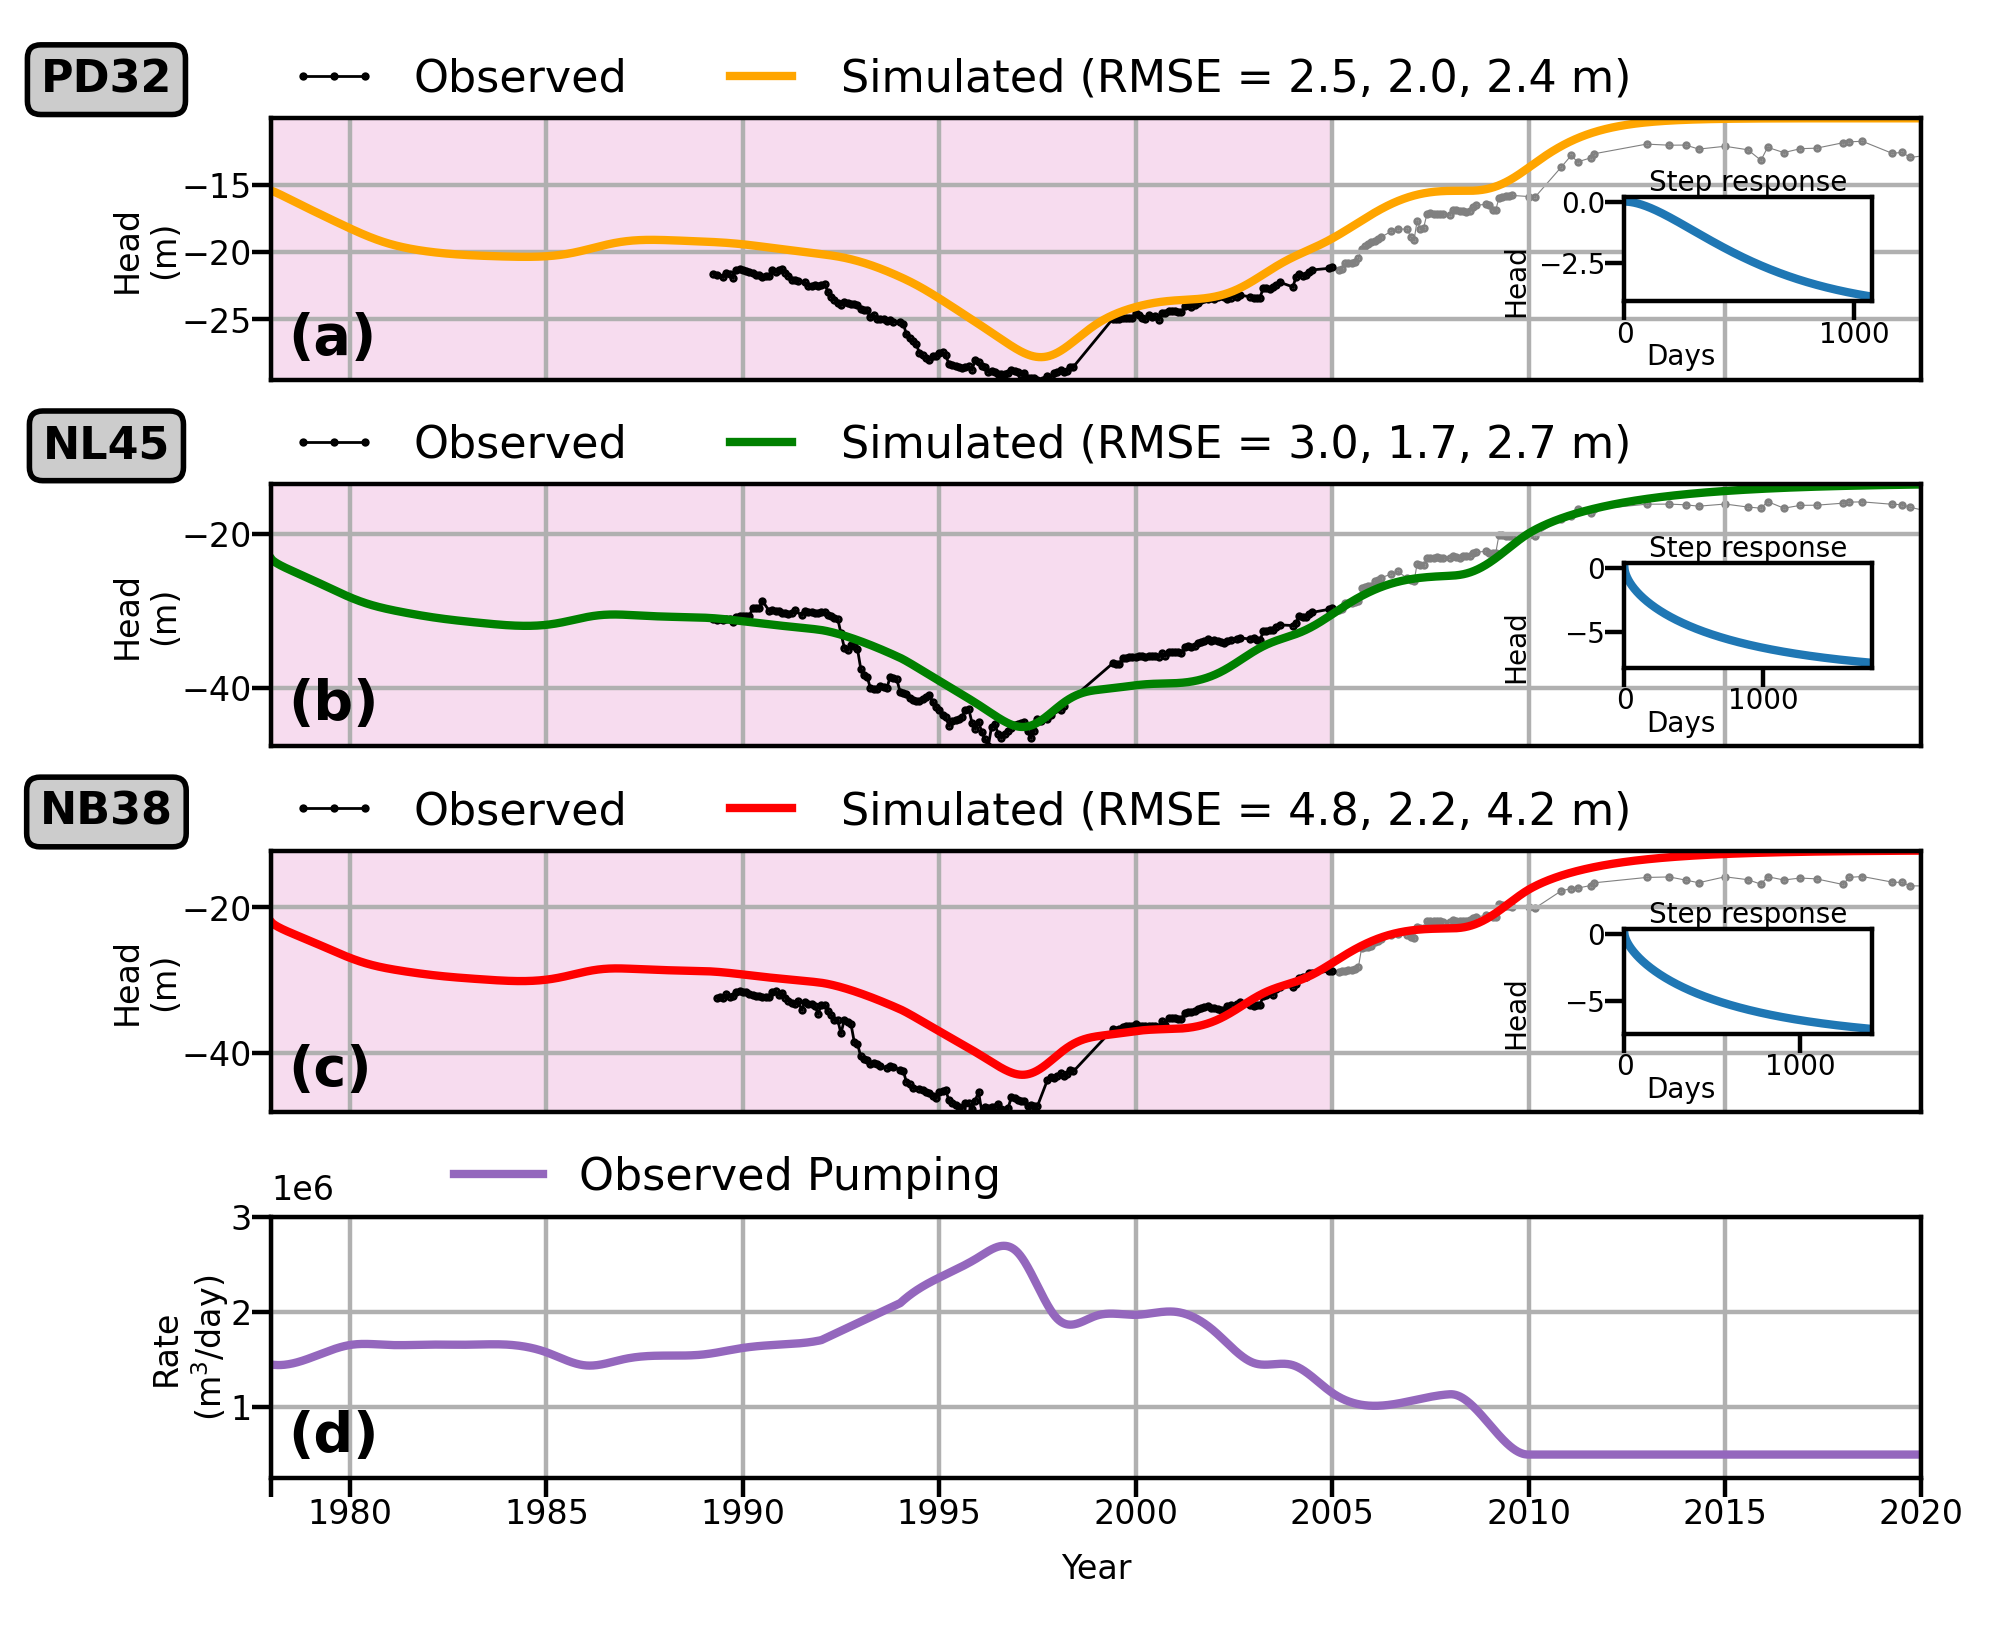

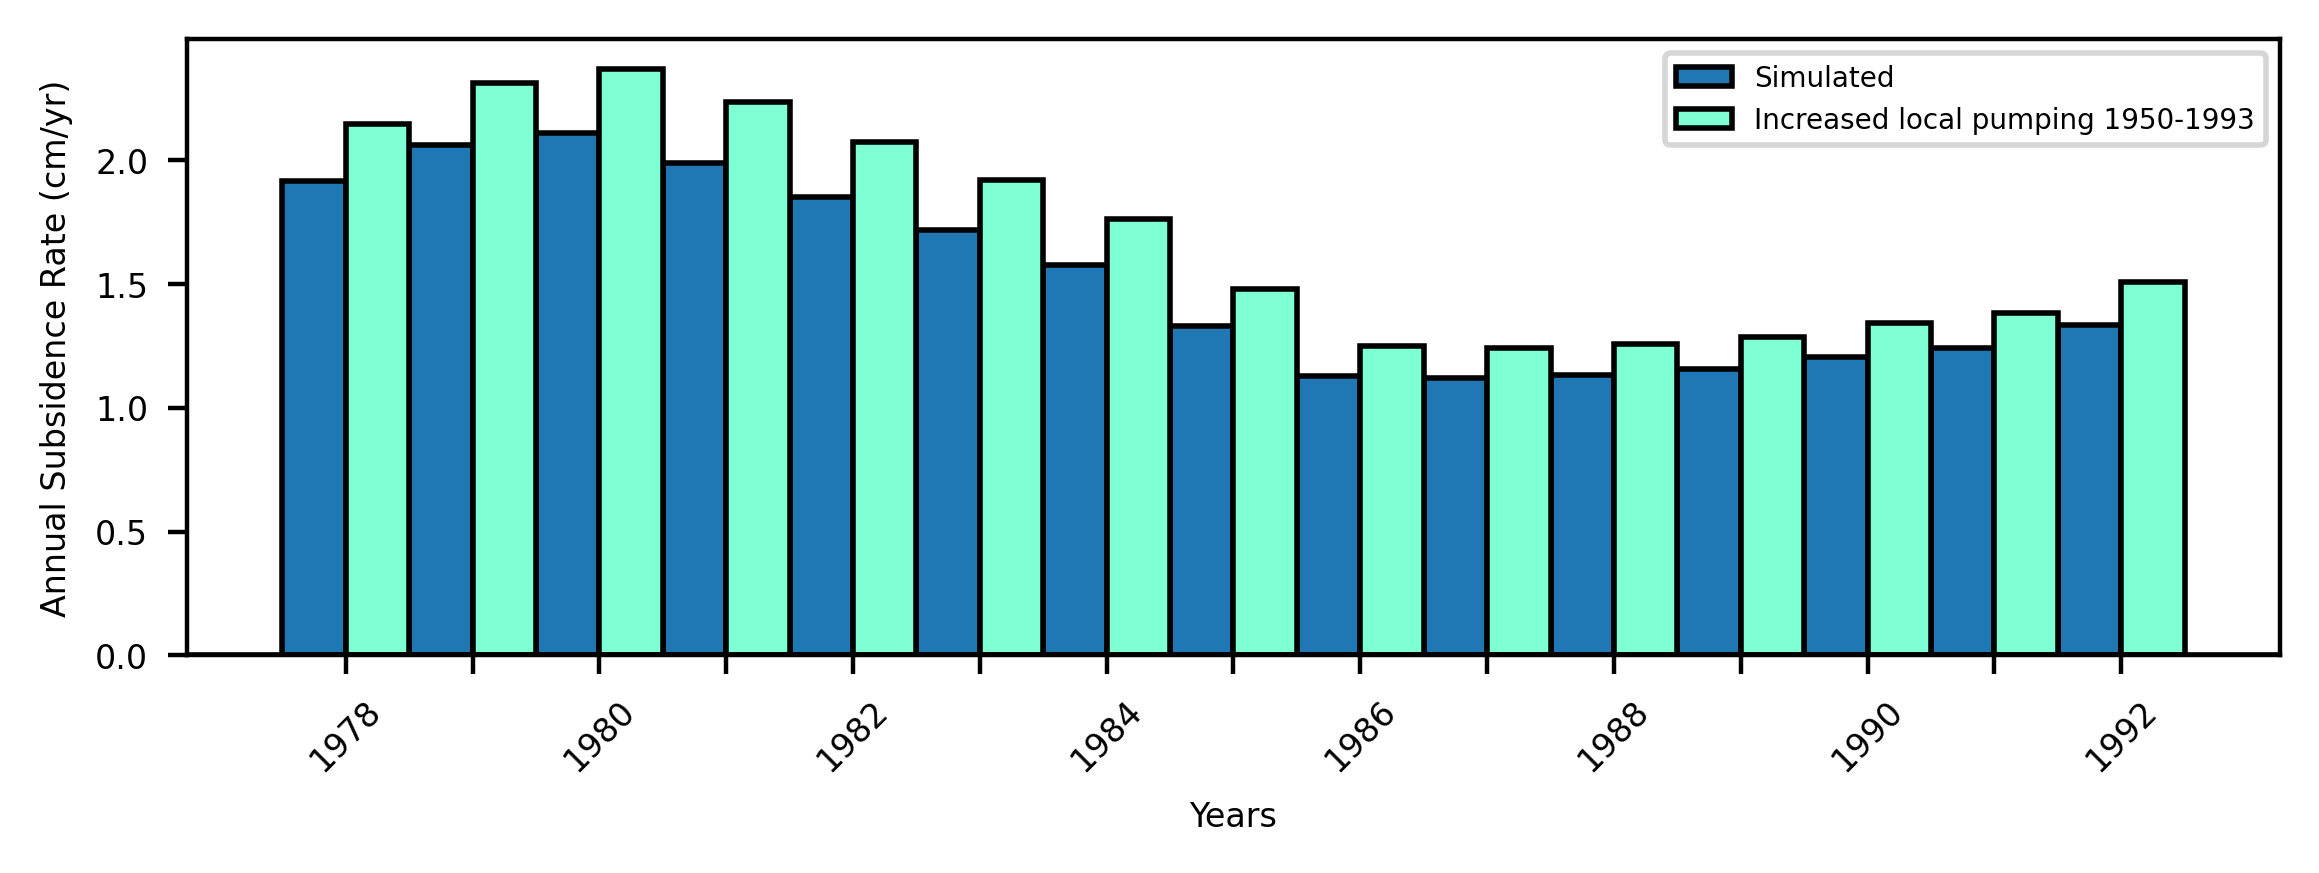

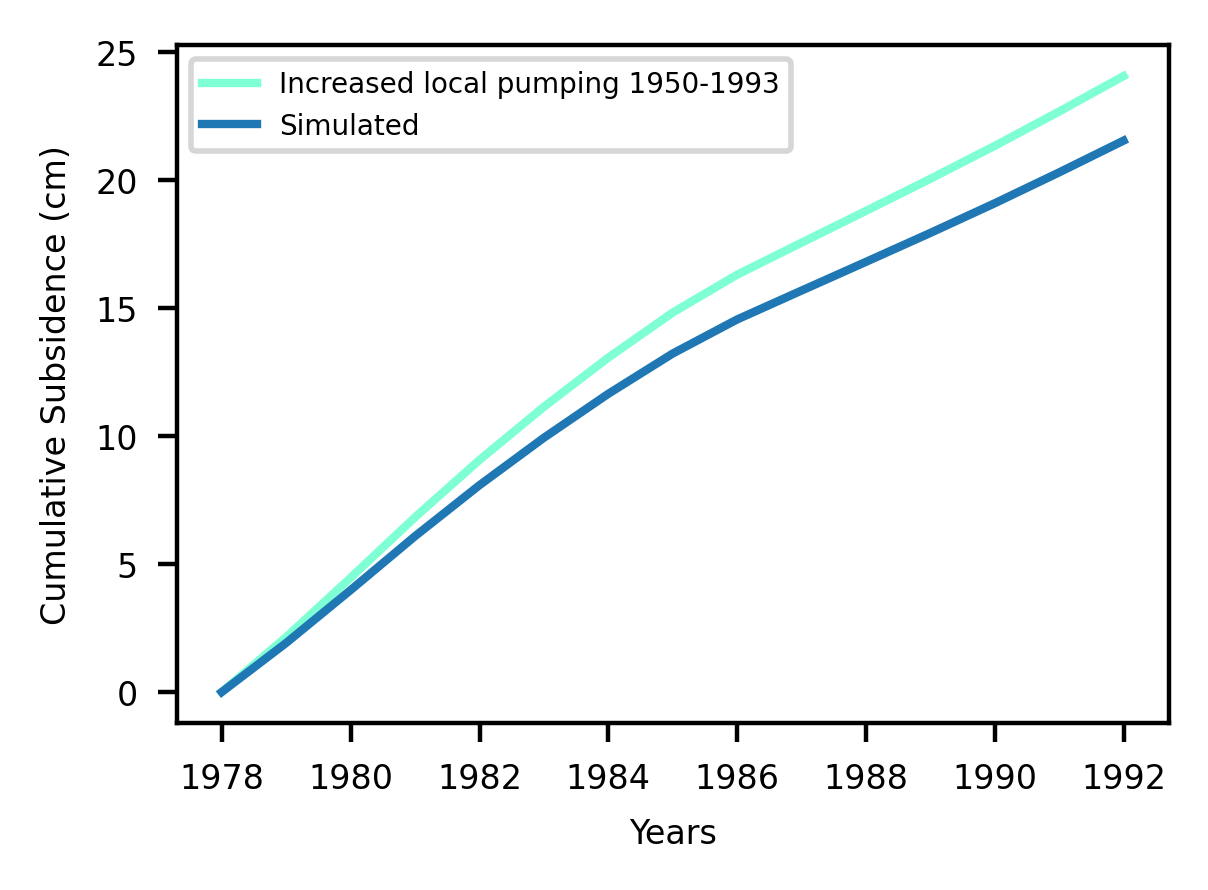

In [8]:
# %% Supplemental Information figures 1.72-1.74
# What if pumping increased for 1950-1993
# Sensitivity analysis

# If saving graphs, save_graph = 1
save_graph = 1

# Publication graphs
paper_graph = 1


# Folder to save/import graph and model
modelpath = os.path.abspath("models")
figpath = os.path.abspath("figures")
pumppath = os.path.join(os.path.abspath("inputs"), "BasinPumping.xlsx")
pumpsheet = "EstTotalPump_54-60_Int50Syn2"

# If running with pumping
# If basin wide pumping set pump_basin_flag to 1
pump_basin_flag = 1

# Pumping response function
pump_rfunc = ps.Gamma()

# Solver
# Options: ps.LmfitSolve, ps.LeastSquares
# solver = ps.LeastSquares()

# Noise model
noise_TF = True

# Option to run all well nests, set flag to 1
list_wellnest_flag = 0

# If running only one well nest, set flag to 0, WellNest Name
Wellnest_name = ["LCBKK013"]

# Getting a list of all the wells
# Total path
tot_path = os.path.abspath("inputs")

# All well nest list
if list_wellnest_flag == 1:

    files = os.listdir(tot_path)
    files = [i.replace(".xlsx", "") for i in files
             if i.startswith("LC") and "_" not in i]

else:
    files = Wellnest_name

###############################################################################
# Creating/Importing and Plotting Pastas Model
###############################################################################

# For each well nest
for Wellnest_name in files:

    # Only open figures for each well nest
    plt.close("all")

    # Saving results for each well nest
    models = []
    time_mins = []
    time_maxs = []
    well_names = []
    # model time_mins
    mod_time_mins = []

    # Reading in groundwater data
    full_path = os.path.join(tot_path, Wellnest_name + ".xlsx")
    data = pd.read_excel(full_path, skiprows=3)

    # For all wells in well nest
    for wells in data.columns[-(len(data.columns)-2):]:

        # Name of well as a string
        well_name = wells

        # Model files
        modelfiles = os.listdir(modelpath)

        # If file exists:
        try:

            # Load existing model
            wellmodel = [s for s in modelfiles
                         if np.logical_and(Wellnest_name in s,
                                           well_name in s)][0]
            model = ps.io.load(modelpath + "/" + wellmodel)

            # Gets time min and max from file name
            time_min = wellmodel[wellmodel.find("_1")+1:wellmodel.find("_1")+5]
            time_max = wellmodel[wellmodel.find("_2")+1:wellmodel.find("_2")+5]

            # Saving optimal parameters before deleting stress
            optiparam = model.parameters["optimal"]
            stdparam = model.parameters["stderr"]

            # Model time_mins
            mod_time_mins.append(time_min)

            # Deleting stress
            model.del_stressmodel("well")

            # Adding new pumping stress time series
            # If the same pumping stress time series, then
            # optimal parameters are the same
            EstTotPump = pd.read_excel(pumppath, sheet_name=pumpsheet,
                                       index_col=0, parse_dates=["Date"])
            EstTotPump_ = ps.StressModel(EstTotPump.Pump, rfunc=pump_rfunc,
                                         name="well", settings="well",
                                         up=False)

            # Adding new stress model
            model.add_stressmodel(EstTotPump_)

            # Setting the same optimal parameters
            model.parameters["optimal"] = optiparam
            model.parameters["stderr"] = stdparam

        # If does not exist
        except FileNotFoundError:
            print("No model for " + Wellnest_name + "_" + well_name)
            continue

        # Saving Pastas model, Well_name
        models.append(model)
        well_names.append(well_name)

        ###########################################################################
        # Pastas Plotting and Graphing
        ###########################################################################

        # set plotting time min and time max
        if "BK" in well_name:
            ptime_min = "1986"
        else:
            ptime_min = "1978"
        ptime_max = "2020"

        # Saving time_mins and time_maxs
        time_mins.append(ptime_min)
        time_maxs.append(ptime_max)

    # If replicating publication figures
    if paper_graph == 1:

        # Calibrating
        # If calibration and validating
        califlag = [min(mod_time_mins), time_max]
        bkk_sub_gw.bkk_plotting.Pastas_results(models, Wellnest_name,
                                               well_names, time_mins,
                                               time_maxs, figpath, save_graph,
                                               califlag=califlag)

# NEW MODEL
# Creating (0) or importing (1)
importing = 0

# If saving model
saving = 1

# For well nest BKK013 (in paper) = LCBKK013
wellnestlist = ["LCBKK013"]

# If creating results for first time
if importing == 0:

    tmin = "1978"
    tmax = "2020"

    # Reading in thickness and storage data
    path = os.path.join(os.path.abspath("inputs"), "SUBParameters.xlsx")
    Thick_data = pd.read_excel(path, sheet_name="Thickness",
                               index_col=0)  # Thickness
    Sskv_data = pd.read_excel(path,
                              sheet_name="Sskv",
                              index_col=0)  # Sskv
    Sske_data = pd.read_excel(path,
                              sheet_name="Sske",
                              index_col=0)  # Ssk
    K_data = pd.read_excel(path,
                           sheet_name="K",
                           index_col=0)  # K

    # Mode can be "raw" as in raw groundwater data vs "Pastas" for importing Pastas
    # simulated groundwater in the aquifers
    mode = "Pastas"

    # If mode is Pastas, need model path
    if mode == "Pastas":

        mpath = os.path.abspath("models")

    # Pumping flag, for PASTAS, if changing pumping scenario
    pumpflag = 1
    # If changing pumping scenario, need pumping sheet/path
    if pumpflag == 1:

        ppath = os.path.join(os.path.abspath("inputs"), "BasinPumping.xlsx")
        psheet = "EstTotalPump_54-60_Int50Syn2"

    # Convergence criteria
    CC = 1 * 10**-5

    # Number of nodes in clay
    node_num = 10

    # Using available heads as proxy for missing
    proxyflag = 1

    # Calculates subsidence
    all_results, sub_total, subv_total = bkk_sub_gw.\
        bkk_sub.bkk_subsidence(wellnestlist,
                               mode, tmin,
                               tmax,
                               Thick_data,
                               K_data,
                               Sskv_data,
                               Sske_data,
                               CC=CC,
                               Nz=node_num,
                               ic_run=True,
                               proxyflag=proxyflag,
                               pumpflag=pumpflag,
                               pump_path=ppath,
                               pump_sheet=psheet,
                               model_path=mpath)

    # Post process data
    sub_total, subv_total, ann_sub, \
        avgsub = bkk_sub_gw.bkk_sub.bkk_postproc(wellnestlist,
                                                 sub_total,
                                                 subv_total,
                                                 all_results)

    # Dictionary to store everything
    model_subSYN2 = {"wellnestlist": wellnestlist,
                     "all_results": all_results,
                     "sub_total": sub_total,
                     "subv_total": subv_total,
                     "ann_sub": ann_sub,
                     "avgsub": avgsub,
                     "tmin": tmin,
                     "tmax": tmax,
                     "Thick_data": Thick_data,
                     "Sske_data": Sske_data,
                     "Sskv_data": Sskv_data,
                     "K_data": K_data,
                     "pumping_scenario": psheet,
                     "CC": CC,
                     "clay_nodes": node_num,
                     "proxyflag": proxyflag,
                     "mode": mode}

    # If saving model
    if saving == 1:

        # Path to save models
        path = os.path.abspath("models")

        # Saving dict for this model
        afile = open(path + "\\LCBKK013_subSyn2.pkl", "wb")
        pickle.dump(model_subSYN2, afile)
        afile.close()

# if importing subsidence model results
else:

    # Path to import models
    path = os.path.abspath("models")

    # Reload object from file
    file2 = open(path + "\\" + wellnestlist[0] + "_subSyn2.pkl", "rb")
    model_sub = pickle.load(file2)
    file2.close()

# OG MODEL

# If saving model
saving = 0

# For well nest BKK013 (in paper) = LCBKK013
wellnestlist = ["LCBKK013"]

# Path to import models
path = os.path.abspath("models")

# Reload object from file
file2 = open(path + "\\" + wellnestlist[0] + "_sub.pkl", "rb")
model_sub = pickle.load(file2)
file2.close()

# Plotting
# path to save figures
path = os.path.abspath("figures")

# BAR PLOT preparation
daterange = pd.date_range(datetime.datetime(1978, 12, 31), periods=15,
                          freq="Y").tolist()
df = pd.DataFrame(daterange, columns=["date"])

x = np.arange(15)
width = .5

# Figure plotting model results against measurements
# Converts to cm to match measurements
# set fig size certain way if running batch well nests
# Supplemental Information
if len(wellnestlist) > 1:

    plt.figure(figsize=(6.75, 3.38), dpi=400)

# Paper size
else:

    plt.figure(figsize=(6.75, 2), dpi=400)

# Bar graph
# annual data in cm
num_well = 0
plot_data = df.merge(model_sub["ann_sub"][num_well][1]*100, left_on=df.date,
                     right_on=model_sub["ann_sub"][num_well][1].index,
                     how="left")
# Renaming for second merge
plot_data = plot_data.rename(columns={"key_0": "key0"})

# Filling na with 0
plot_data = plot_data.fillna(0)

plt.bar(x,
        -plot_data.AnnRates[:16],
        label="Simulated", width=width,
        linewidth=1, edgecolor="k")

# Renaming for other merge
plot_data = plot_data.rename(columns={"AnnRates": "AnnRatesOG"})

# NEW MODEL WITH PUMPING ALTERED
# Bar plot
# Benchamrks already in cm
plot_data = plot_data.merge(model_subSYN2[
    "ann_sub"][num_well][1]*100, left_on=plot_data.key0, right_on=model_subSYN2[
        "ann_sub"][num_well][1].index, how="left")

# Renaming for other merge
plot_data = plot_data.rename(columns={"key_0": "key1"})

# Filling na with 0
plot_data = plot_data.fillna(0)

plt.bar(x+width, -plot_data.AnnRates[:16],
        label="Increased local pumping 1950-1993", width=width, color="aquamarine",
        linewidth=1, edgecolor="k")

# Dropping NAs
plot_data = plot_data.dropna()

# Plotting settings
plt.legend(loc="upper right")
# set y limits/title only if running batch well nests
if len(wellnestlist) > 1:
    plt.ylim((-2, 10))
    plt.title(wellnest)
plt.ylabel("Annual Subsidence Rate (cm/yr)")
plt.xlabel("Years")

ax = plt.gca()
plt.draw()
plt.axhline(y=0, color="k", linestyle="-", linewidth=1)
ax.set_xticklabels(ax.get_xticks(), rotation=45)
plt.xticks(x+.5*width, ["1978", "", "1980", "", "1982",
                        "", "1984", "", "1986", "",
                        "1988", "", "1990", "", "1992",
                        ])

# Cumulative Plot
# Figure plotting model results cumulative sub for each scenario
fig, ax = plt.subplots(figsize=(3.2, 2.2), dpi=400)
plt.plot(model_subSYN2["ann_sub"][num_well][1].index[:15],
         model_subSYN2["ann_sub"][num_well][1].CumTotSum[:15]*-100,
         label="Increased local pumping 1950-1993", linewidth=1.5,
         color="aquamarine")
plt.plot(model_sub["ann_sub"][num_well][1].index[:15],
         model_sub["ann_sub"][num_well][1].CumTotSum[:15]*-100,
         label="Simulated", linewidth=1.5)
plt.ylabel("Cumulative Subsidence (cm)")
plt.xlabel("Years")
plt.legend()

print("Difference in 1993 (cm): " + str(
    model_subSYN2["ann_sub"][num_well][1].CumTotSum[15] -
    model_sub["ann_sub"][num_well][1].CumTotSum[15]))
print("Difference in 1993 (%): " + str((
    model_subSYN2["ann_sub"][num_well][1].CumTotSum[15] -
    model_sub["ann_sub"][num_well][1].CumTotSum[15]) /
    model_sub["ann_sub"][num_well][1].CumTotSum[15] * 100))